# Doppio clustering

## Import

In [253]:
import numpy as np
import pandas as pd
import os
import h5py
import random
import sys
import corner
import matplotlib.pyplot as plt
import taurex.log
import importlib

# Importa dinamicamente il modulo helper
import helper
importlib.reload(helper) 
check_parameters_valid = helper.check_parameters_valid

# Aggiungi il percorso della directory contenente helper.py
sys.path.append(os.path.abspath('./'))

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
from sklearn.mixture import GaussianMixture
from sklearn import mixture
from bayesian_bootstrap import bayesian_bootstrap
from helper import *
from preprocessing import *
from submit_format import to_competition_format
from posterior_utils import *
from spectral_metric import *
from FM_utils_final import *

# plt.style.use('default')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['red'])

taurex.log.disableLogging()
np.set_printoptions(suppress=True, linewidth=np.nan, threshold=sys.maxsize)

## Setting variabili

In [254]:
n_repeat = 5
random_state = 420

# Lettura dati dai file 
aux = np.load('aux.npy')
spec_matrix = np.load('spectra.npy')
noise = np.load('noise.npy')
labels = np.load('label.npy')
validTraces = np.load('validTraces.npy')

# Definizione dei 7 parametri target (in ordine)
labels_names = ['planet_radius','planet_temp','log_H2O','log_CO2','log_CO','log_CH4','log_NH3']

# Setting dei path
training_path = './Full_Dataset/Level2Data/'
training_GT_path = os.path.join(training_path, 'Ground Truth Package')
trace_GT = h5py.File(os.path.join(training_GT_path, 'TraceData.hdf5'), "r")

validTraces = validTraces.astype(int)
num_spectra = spec_matrix.shape[0]

vt = validTraces
test_ind = np.sort(vt - 1)
train_ind = np.setdiff1d(np.arange(num_spectra), test_ind)
plot_ind = random.sample(range(len(test_ind)), 10)
spectra_ind = random.sample(range(len(test_ind)), 10)

# Preprocessing dei dati spettrali
test_spectra = spec_matrix[test_ind, :]
test_spectra = augment_data(test_spectra, noise[test_ind, :], repeat=1)
test_spectra = test_spectra.reshape(-1, spec_matrix.shape[1])
test_spectra = normalize(test_spectra, axis=0, norm='max')

train_spectra = spec_matrix[train_ind, :]
train_spectra = augment_data(train_spectra, noise[train_ind, :], repeat=n_repeat)
train_spectra = train_spectra.reshape(-1, spec_matrix.shape[1])
train_spectra = normalize(train_spectra, axis=0, norm='max')

# Dati ausiliari e labels
train_aux = aux[train_ind, :]
train_aux = np.repeat(train_aux, repeats=n_repeat, axis=0)
test_aux = aux[test_ind, :]

train_labels = labels[train_ind, :]
train_labels = np.repeat(train_labels, repeats=n_repeat, axis=0)
test_labels = labels[test_ind, :]

# Controllo della compatibilità dei dati per il modello
RJUP = 69911000
MJUP = 1.898e27
RSOL = 696340000
Rs = aux[:, 2] / RSOL  # star_radius in unità solari
Mp = aux[:, 4] / MJUP  # planet_mass in unità di massa gioviana
n_samples = 1000

# Applicazione del Clustering
- $K_1$ : numero di cluster di 1o livello
- $K_2$ : numero di 'sottocluster' (cluster di 2o livello)
- $GMM_i$ : output del Gaussian Mixture Model
- $Labels_i$ : labels ottenute dal GMM
> Cerchiamo, in ogni sottocluster (K2), i cluster contenenti un singolo spettro, che sono considerati *outlier*, cioe' anomali (composti da un solo spettro)
### Si puo' usare il BIC (o l'AIC) per ottenere **i valori ottimali** di $K_1$ e $K_2$

In [255]:
K1 = 10  # Numero di cluster di primo livello
K2 = 20  # Numero di sottocluster per ciascun cluster di secondo livello
GMM_i = []
Labels_i = []

'''
## UTILIZZO Bayesian Information Criterion e Akaike Information Criterion per capire quali valori dare a K1 e K2
n_components_range = range(1, 10)
bic_scores = []
aic_scores = []

for n in n_components_range:
    gmm_tmp = GaussianMixture(n_components=n,random_state=random_state,max_iter=500).fit(train_aux)
    bic_scores.append(gmm_tmp.bic(train_aux))
    aic_scores.append(gmm_tmp.aic(train_aux))

# Trova il numero di componenti con il minimo BIC e AIC
best_n_components_bic = n_components_range[np.argmin(bic_scores)]
best_n_components_aic = n_components_range[np.argmin(aic_scores)]

K1 = best_n_components_bic
K2 = best_n_components_aic
'''
# Primo clustering con GaussianMixture su train_aux
gmm = mixture.GaussianMixture(n_components=K1, random_state=random_state, max_iter=500,covariance_type='diag',reg_covar=1e-6).fit(train_aux)
labels_1 = gmm.predict(train_aux)
for i in range(K1):
    spectra_i = np.where(labels_1 == i)[0]
    print("Spettri nel cluster #", i, " -> ", len(spectra_i))
    # Secondo clustering (2° livello) sui dati spettrali appartenenti al cluster i
    tmp = mixture.GaussianMixture(n_components=K2, random_state=random_state, max_iter=500).fit(train_spectra[spectra_i, :])
    labels_2 = tmp.predict(train_spectra[spectra_i, :])
    GMM_i.append(tmp)
    Labels_i.append(labels_2)
    for j in range(K2):
        spectra_j = np.where(labels_2 == j)[0]
        if len(spectra_j) == 1:
            print(f"\t [{i}].{j} sottocluster con singolo spettro [OUTLIER]")

Spettri nel cluster # 0  ->  23350
Spettri nel cluster # 1  ->  22855
Spettri nel cluster # 2  ->  11360
Spettri nel cluster # 3  ->  17305
Spettri nel cluster # 4  ->  2755
Spettri nel cluster # 5  ->  11750
Spettri nel cluster # 6  ->  24780
Spettri nel cluster # 7  ->  28720
Spettri nel cluster # 8  ->  24195
Spettri nel cluster # 9  ->  6215


## Setup per gli score

In [256]:
posterior_scores = []
spectral_scores = []
bounds_matrix = default_prior_bounds()  
## DEBUG :
# print(bounds_matrix.shape)
beta = 0.8
q_list = np.linspace(0.01, 0.99, 10)
# Variabili per il modello forward
opacity_path = "./XSEC/"
CIA_path = "./HITRAN"
ariel_wlgrid, ariel_wlwidth, ariel_ngrid, ariel_wnwidth = ariel_resolution()
fm = initialise_forward_model(opacity_path, CIA_path)


Layer: 0
  planet_radius: 71492000.0
  dz[0]: 36849.43465575589
  z[layer+1:]: [  36849.43465576   73736.86603237  110662.35291962  147625.95422865  184627.72899221  221667.73636501  258746.03562406  295862.68616892  333017.74752208  370211.27932924  407443.34135966  444713.99350642  482023.29578684  519371.30834269  556758.0914406   594183.70547233  631648.21095515  669151.6685321   706694.13897235  744275.68317155  781896.36215211  819556.23706359  857255.36918296  894993.81991499  932771.65079257  970588.92347702 1008445.69975845 1046342.04155609 1084278.01091862 1122253.67002454 1160269.08118244 1198324.30683143 1236419.4095414  1274554.45201342 1312729.49708007 1350944.60770575 1389199.84698709 1427495.27815322 1465830.9645662  1504206.96972129 1542623.35724738 1581080.19090726 1619577.53459805 1658115.45235149 1696694.00833432 1735313.26684866 1773973.29233233 1812674.14935922 1851415.90263967 1890198.61702078 1929022.35748683 1967887.18915961 2006793.1772988  2045740.3873023  2

C:\Users\milit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\taurex\model\transmission.py:274: RuntimeWarning: overflow encountered in exp
  tau = np.exp(-tau)


### Calcolo degli score

In [257]:
for X in range(len(test_ind)):
    try:
        # Selezione dei cluster per il test sample X
        idx1 = gmm.predict(test_aux[X, :].reshape(1, -1))[0]
        km = GMM_i[idx1]
        labels_2 = Labels_i[idx1]
        idx2 = km.predict(test_spectra[X, :].reshape(1, -1))[0]
        # Trova gli indici corrispondenti nel training set
        idx_1 = np.where(labels_1 == idx1)[0]
        idx_2 = np.where(labels_2 == idx2)[0]
        # Se non ci sono campioni nel cluster corrispondente, salta questo test sample
        common_indices = np.intersect1d(idx_1, idx_2) # Get common indices
        if len(common_indices) == 0: # Check common indices length
            continue
        lab = train_labels[common_indices,:]
        posterior = lab
        # weights1 = km.predict_proba(train_spectra[idx_1[idx_2],:])[:,idx2] # Commented out weights calculation
        # weights1 = weights1 / np.min(weights1)
        # weights1 = weights1 / sum(weights1)
        # weights1 = np.ones((lab.shape[0],1)) / np.sum(np.ones(lab.shape[0]))
        weights1 = np.ones((posterior.shape[0],1)) / np.sum(np.ones(posterior.shape[0]))
        planet_index = test_ind[X] + 1 # Corrected Planet Index calculation
        tr_GT = trace_GT[f'Planet_{planet_index}']['tracedata'][()] # Corrected Planet ID format
        wh_GT = trace_GT[f'Planet_{planet_index}']['weights'][()] # Corrected Planet ID format

        if isinstance(tr_GT, tuple):
            if not tr_GT:
                # print("tr_GT is an empty tuple, skipping")
                continue
            tr_GT = tr_GT[0]
        if not isinstance(tr_GT, np.ndarray):
            # print("tr_GT is not a numpy array, skipping")
            continue
        if posterior.shape[0] < 2:
            # print("posterior.shape[0] < 2, skipping")
            continue
        if np.isnan(tr_GT).sum() > 0 or np.isinf(tr_GT).sum() > 0:
            # print("tr_GT contains NaNs or Infs, skipping")
            continue
        if np.isnan(weights1).sum() > 0 or np.isinf(weights1).sum() > 0:
            # print("weights1 contains NaNs or Infs, skipping")
            continue

        score = compute_posterior_loss(posterior, weights1, tr_GT, wh_GT, bounds_matrix)
        posterior_scores.append(score)

        if X in spectra_ind:
            proxy_compute_spectrum = setup_dedicated_fm(fm, X, Rs, Mp, ariel_ngrid, ariel_wnwidth) # Keep ariel_wngrid as in the original code
            score = compute_spectral_loss(posterior, weights1, tr_GT, wh_GT, bounds_matrix, proxy_compute_spectrum, q_list)
            spectral_scores.append(score)

    except KeyError as e:
        # print(f"Skipping sample {X} due to KeyError: {e}")
        # raise
        continue
    except Exception as e:
        # print(f"Skipping sample {X} due to error: {e}")
        # raise
        continue

# Calcolo degli score medi
- Posterior Score : 80%
- Spectral Score : 20%
- Final score = Score finale per la Leaderboard

In [258]:
avg_posterior_score = np.mean(posterior_scores) if posterior_scores else np.nan
print(f'Posterior_Score: {avg_posterior_score}')

avg_spectral_score = np.mean(spectral_scores) if spectral_scores else np.nan
print(f'Spectral_Score: {avg_spectral_score}')

final_score = (1 - beta) * avg_spectral_score + beta * avg_posterior_score if (posterior_scores and spectral_scores) else np.nan
print(f"final loss is {final_score:.4f}")

Posterior_Score: nan
Spectral_Score: nan
final loss is nan


## Function per i plot con Corner

In [259]:
def create_corner_plot(tr_GT, lab, labels_names, X):
    """
    Parametri:
      - tr_GT: array (n_samples, n_params) del Ground Truth.
      - lab: array (n_samples, n_params) dei dati predetti.
      - labels_names: lista dei nomi dei parametri.
      - X: indice per salvare il plot.
    """
    # Crea il corner plot di base per tr_GT
    figure = corner.corner(
        tr_GT, quiet=True, color='black', bins=50, plot_contours=True,
        hist_kwargs={
            'density': True,
            'histtype': 'step', 
            'facecolor': 'lightgray',
            'linewidth': 2.0,
            'edgecolor': 'black',
            'fill': False
        },
        contour_kwargs={'colors': 'black'}
    )
    # Aggiungi le medie come linee verticali sugli assi diagonali
    axes = np.array(figure.axes).reshape((tr_GT.shape[1], tr_GT.shape[1]))
    for i in range(tr_GT.shape[1]):
        ax = axes[i, i]
        ax.axvline(np.mean(tr_GT[:, i]), color="black", linestyle='-', label='tr_GT')
        ax.set_title(labels_names[i])
    
    figure.set_figheight(8.5)
    figure.set_figwidth(12)
    # Sovrapponi il plot dei dati "lab" in rosso
    corner.overplot(
        figure,
        lab,
        quiet=True,
        color='red',
        plot_contours=True,
        hist_kwargs={
            'density': False,
            'histtype': 'step',
            'linewidth': 2.0,
            'facecolor': 'red',
            'edgecolor': 'red',
            'fill': True
        },
        contour_kwargs={'colors': 'red', 'linewidths': 2.0}
    )
    
    plt.suptitle('Corner Plot', fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plot_filename = f'./GMM_plots/corner_plot_{X}.png'
    plt.savefig(plot_filename)
    plt.show()

# Plotting delle distribuzioni
### Si utiliza 'corner' per il plot delle distribuzioni bayesiane a posteriori

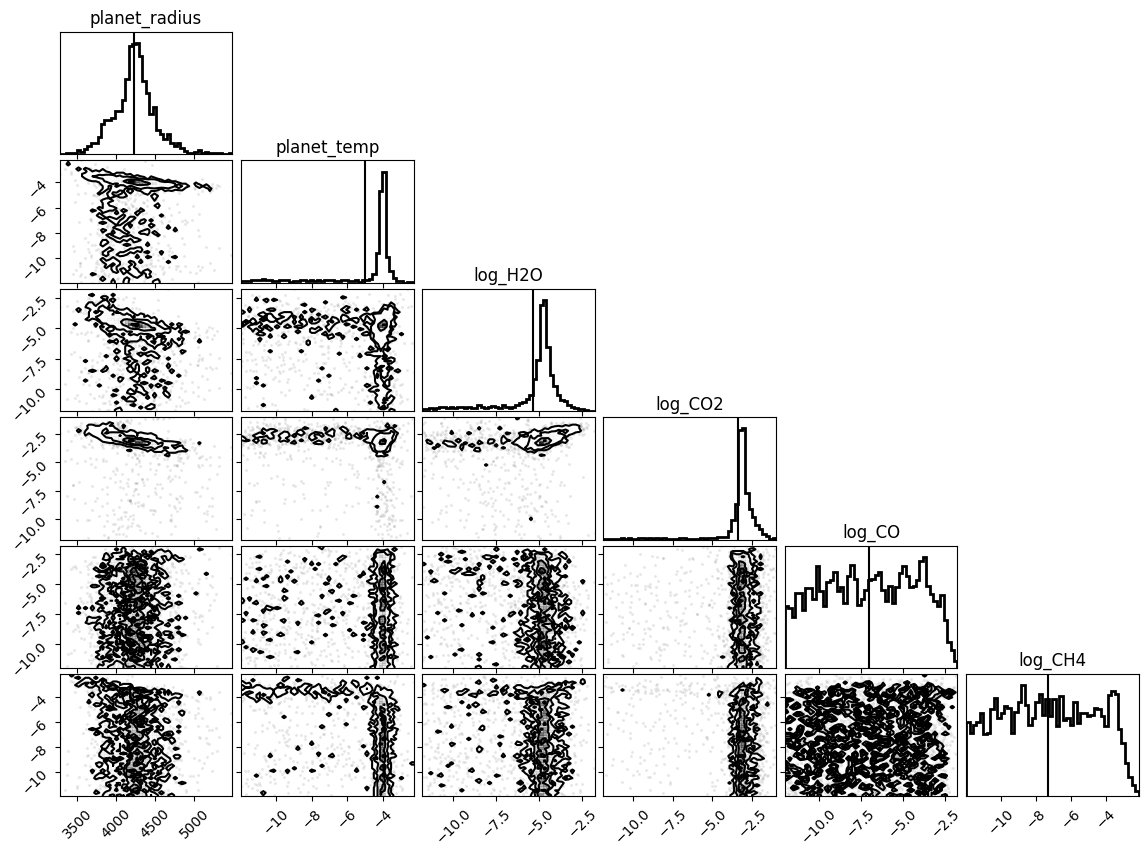

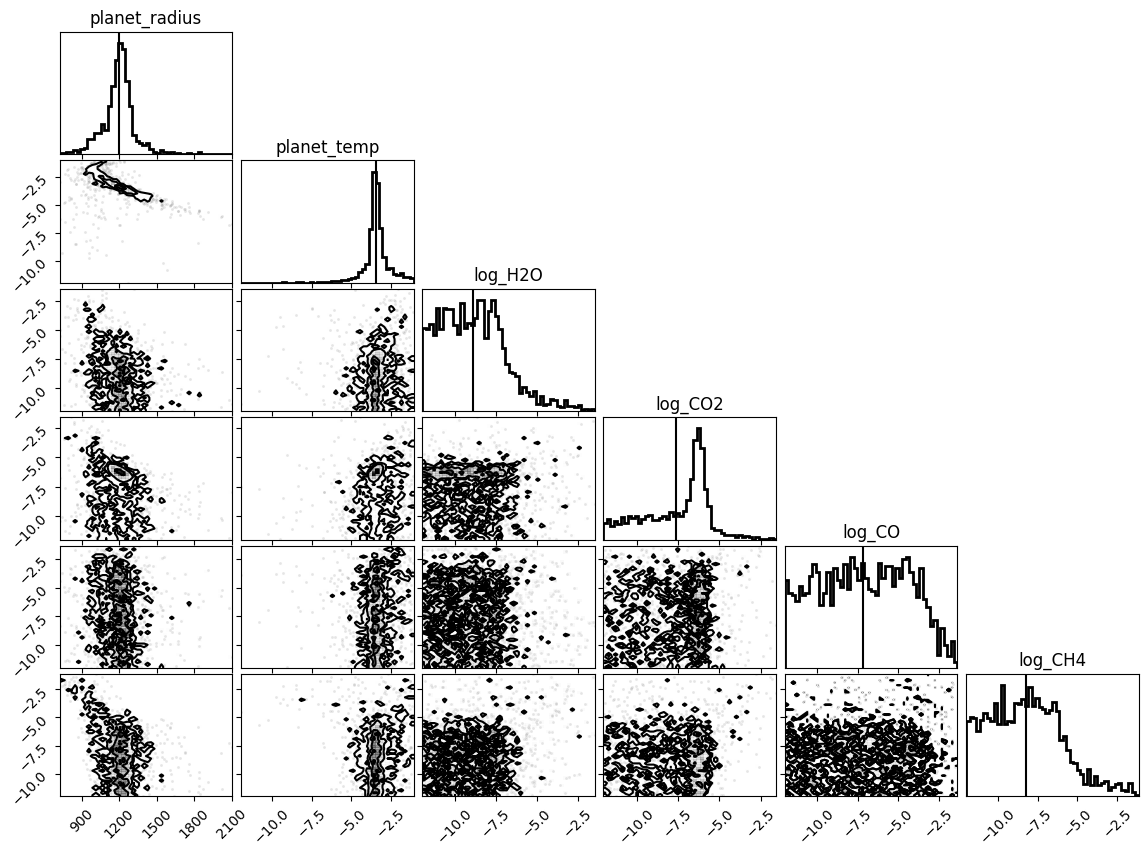

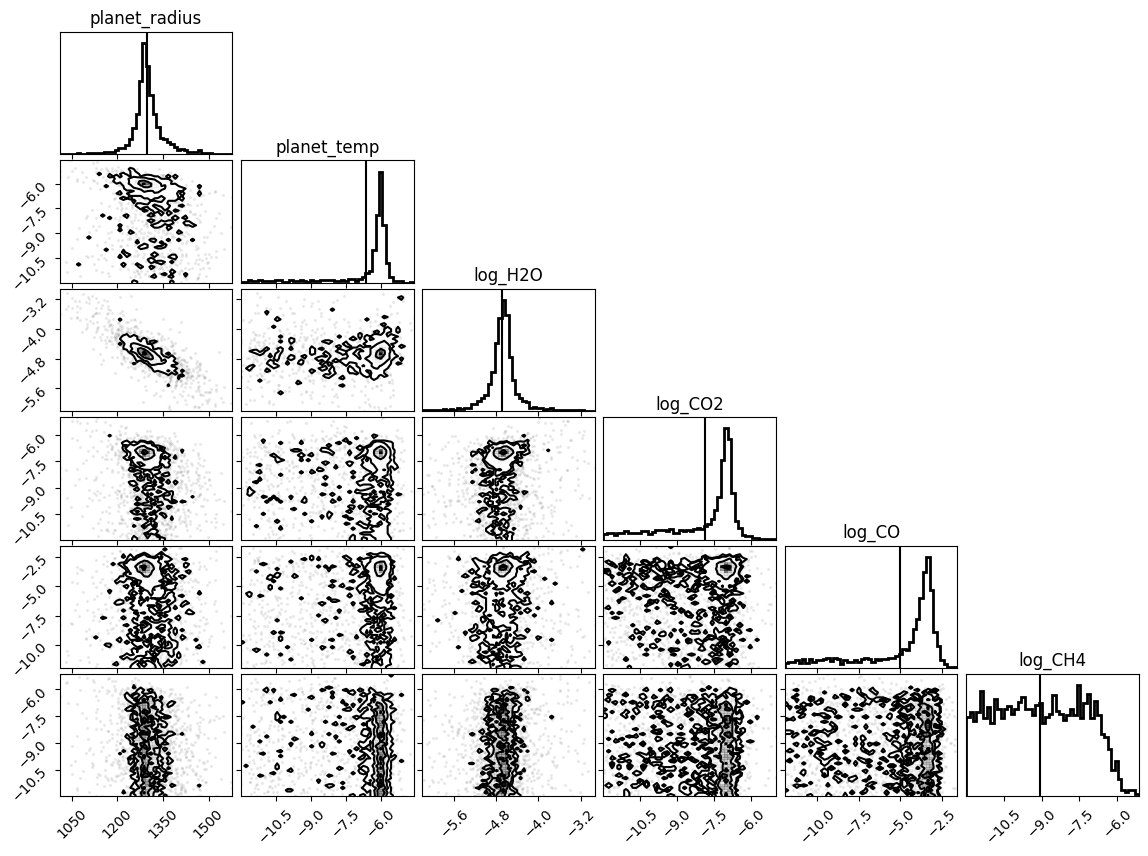

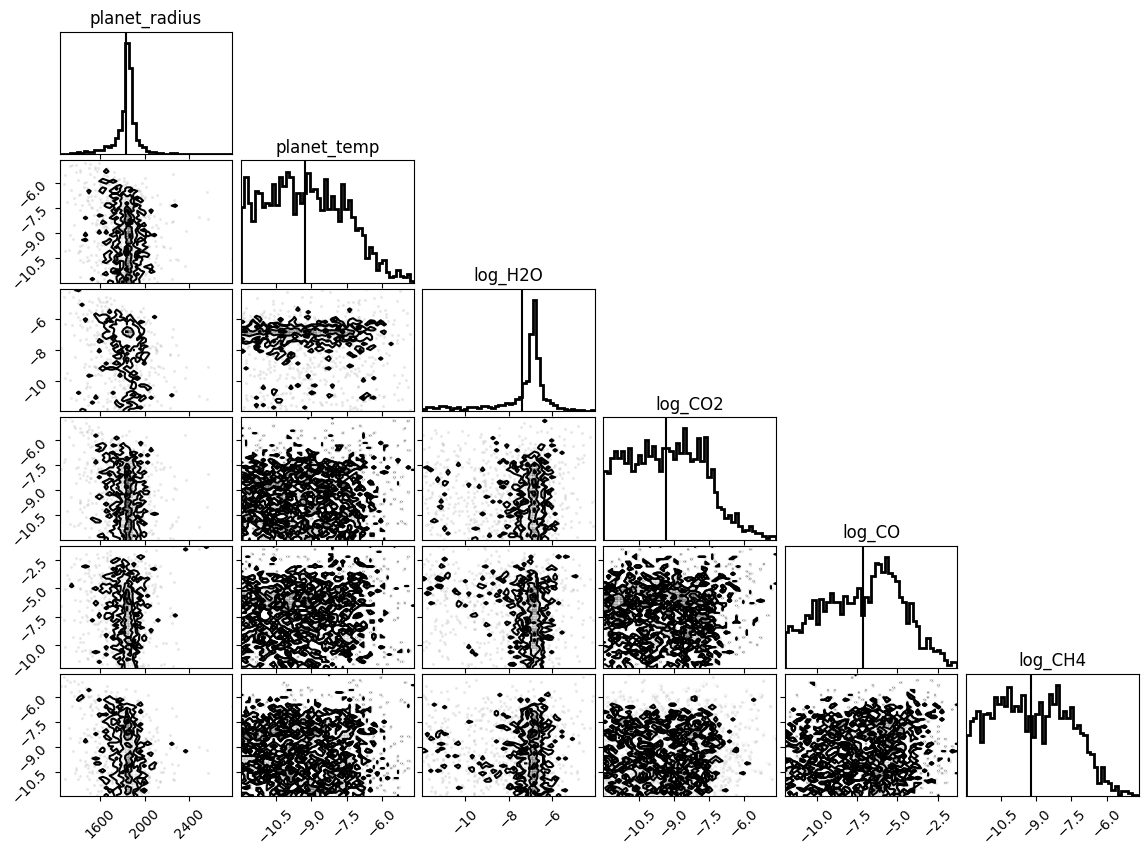

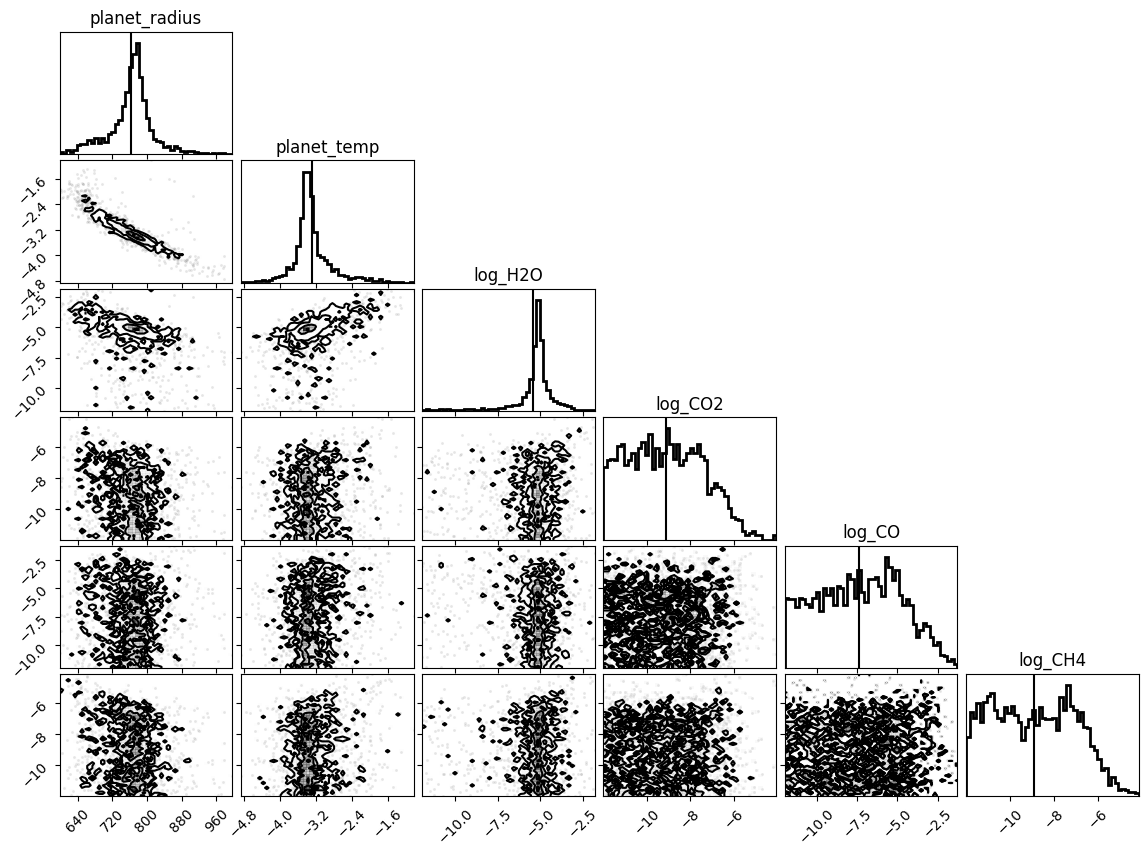

In [260]:
for X in plot_ind:
    try:
        # Selezione dei cluster per il test sample X
        idx1 = gmm.predict(test_aux[X, :].reshape(1, -1))[0]
        km = GMM_i[idx1]
        labels_2 = Labels_i[idx1]
        idx2 = km.predict(test_spectra[X, :].reshape(1, -1))[0]

        # Trova gli indici corrispondenti nel training set
        idx_1 = np.where(labels_1 == idx1)[0]
        idx_2 = np.where(labels_2 == idx2)[0]

        # Corrected indexing: Find intersection of idx_1 and idx_2
        common_indices = np.intersect1d(idx_1, idx_2)
        lab = train_labels[common_indices, :] 
        p_ID = test_ind[X] + 1  # Gli ID dei pianeti sono 1-indexed
        planet_id = f'Planet_{p_ID}'
        with h5py.File(os.path.join(training_GT_path, 'TraceData.hdf5'), "r") as trace_GT:
            tr_GT = trace_GT[f'Planet_{p_ID}']['tracedata'][()]
            if isinstance(tr_GT, tuple):
                if not tr_GT:
                    continue
                tr_GT = tr_GT[0]
            if not isinstance(tr_GT, np.ndarray):
                continue
        create_corner_plot(tr_GT, lab, labels_names, X)
    except KeyError as e:
        # print(f"Skipping plot {X} due to KeyError: {e}")
        continue
    except Exception as e:
        # print(f"Skipping plot {X} due to an unexpected error: {e}")
        continue    